In [1]:
import os
import numpy as np
import random
import pandas as pd
pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots

import tensorflow as tf

from SOAI.handler.SOAIDiskHandler import SOAIDiskHandler

INFO - __init__ : <module>() - Use /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/.. as project path.
WARNING - __init__ : <module>() - SOAI_MODEL_PATH not set
INFO - __init__ : <module>() - SOAI env var is set to /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/..


## Helper functions

In [2]:
def printLists(sensorIDs, dataNO2List, dataTrafficList):
    for sensor, dataNO2, dataTraffic in zip(sensorIDs, dataNO2List, dataTrafficList):
        print(f"====== Sensor {sensor} =======")
        print("*** Sensor data ***")
        print(f"Lenght of sensor data {len(dataNO2)}")
        print(dataNO2.head())
        print("\n")
        print("*** Traffic data ***")
        print(f"Lenght of traffic data {len(dataTraffic)}")
        print(dataTraffic.head())
        print("\n")

## Load data

In [3]:
dataHandler = SOAIDiskHandler()

dfOpenAir = dataHandler.fGetOpenAir(os.environ.get("SOAI") + "/data/openair/", selectValidData=True)
dfOpenAirLocation = dataHandler.fGetOpenAirSensors()

dfLanuv = dataHandler.fGetLanuv(os.environ.get("SOAI") + "/data/lanuv/", selectValidData=True)
dfLanuv.index = dfLanuv.index.tz_localize(None)  # Needed to joind with traffic data later on
dfLanuv.index =  pd.to_datetime(dfLanuv.index, format='%Y-%m-%d %H:%M:%S')
dfLanuvLocation = dataHandler.fGetLanuvSensors()

dfTraffic = dataHandler.fGetTrafficData(os.environ.get("SOAI") + "/data/traffic/")

DEBUG - SOAIDiskHandler : fGetOpenAir() - Load OpenAir Cologne data from /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/.
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair6.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair2.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair4.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair3.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/school_of_ai/projects/air-quality-backend/SOAI/../data/openair/df_openair5.parquet
DEBUG - SOAIDiskHandler : fGetOpenAir() - 	- Load /home/nils/workspace/

In [4]:
dfTraffic.head()

,green,orange,red,brown,pixelCounterSensor,rgreen,rorange,rred,rbrown,sensorID,pixel
date,,,,,,,,,,,
2019-08-01,2313.0,0.0,0.0,0.0,2313.0,1.0,0.0,0.0,0.0,VKCL,20
2019-08-01,647.0,0.0,0.0,0.0,647.0,1.0,0.0,0.0,0.0,VKCL,5
2019-08-01,943.0,0.0,0.0,0.0,943.0,1.0,0.0,0.0,0.0,VKTU,10
2019-08-01,382.0,0.0,0.0,0.0,382.0,1.0,0.0,0.0,0.0,VKCL,3
2019-08-01,1811.0,0.0,0.0,0.0,1811.0,1.0,0.0,0.0,0.0,VKTU,20


## Filter and prepare data

In [5]:
# Choose the sensors and the pixel size around each sensor

#sensorIDs = ["VKCL", "CHOR", "VKTU", "RODE"]
#sensorIDs = ["VKCL", "VKTU"]
sensorIDs = ["VKCL"]

pixelAroundSensor = 5

In [6]:
# Use list to process data, since multiple sensor can be used for training
# Each element in the list corresponds to one dataframe for one sensor
dataNO2List = []
dataTrafficList = []

for sensor in sensorIDs:
    dataNO2 = dfLanuv[dfLanuv["sensorID"] == sensor]
    dataNO2List.append(dataNO2)
    
    dataTraffic = dfTraffic[dfTraffic["sensorID"] == sensor]
    dataTraffic = dataTraffic[dataTraffic["pixel"] == pixelAroundSensor]
    dataTrafficList.append(dataTraffic)
    
printLists(sensorIDs, dataNO2List, dataTrafficList)

====== Sensor VKCL =======
*** Sensor data ***
Lenght of sensor data 11713
                    sensorID    NO  OZON   no2  wr  wg  temp  wtime  hum
timestamp                                                               
2018-08-14 08:00:00     VKCL  92.0   NaN  53.0 NaN NaN   NaN    NaN  NaN
2018-08-14 10:00:00     VKCL  78.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 11:00:00     VKCL  68.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 12:00:00     VKCL  70.0   NaN  55.0 NaN NaN   NaN    NaN  NaN
2018-08-14 13:00:00     VKCL  82.0   NaN  75.0 NaN NaN   NaN    NaN  NaN


*** Traffic data ***
Lenght of traffic data 20140
                     green  orange  red  brown  pixelCounterSensor  rgreen  \
date                                                                         
2019-08-01 00:00:00  647.0     0.0  0.0    0.0               647.0     1.0   
2019-08-01 00:15:00  614.0     0.0  0.0    0.0               614.0     1.0   
2019-08-01 00:30:00  644.0     0.0  0.0    0.0    

Resample data and keep overlapp between no2 dataframe and traffic dataframe

In [7]:
for i in range(len(sensorIDs)):
    dataNO2List[i] = dataNO2List[i].resample("1h").mean()
    dataTrafficList[i] = dataTrafficList[i].resample("1h").mean()
    
    timeMin = max(dataNO2List[i].index.min(), dataTrafficList[i].index.min())
    timeMax = min(dataNO2List[i].index.max(), dataTrafficList[i].index.max())

    dataNO2List[i] = dataNO2List[i].loc[(dataNO2List[i].index >= timeMin) & (dataNO2List[i].index <=   timeMax)]
    dataTrafficList[i] = dataTrafficList[i].loc[(dataTrafficList[i].index >= timeMin) & (dataTrafficList[i].index <= timeMax)]

Enrich features and interpolate

In [8]:
for i in range(len(sensorIDs)):
    dataNO2List[i]["wr_cos"] = dataNO2List[i]["wr"].apply(lambda x: np.cos(x))
    dataNO2List[i]["wr_sin"] = dataNO2List[i]["wr"].apply(lambda x: np.sin(x))

    dataNO2List[i]["no2_ip"] = dataNO2List[i].interpolate()["no2"]
    dataNO2List[i]["wg_ip"] = dataNO2List[i].interpolate()["wg"]
    dataNO2List[i]["hum_ip"] = dataNO2List[i].interpolate()["hum"]
    dataNO2List[i]["temp_ip"] = dataNO2List[i].interpolate()["temp"]
    dataNO2List[i]["wr_cos_ip"] = dataNO2List[i].interpolate()["wr_cos"]
    dataNO2List[i]["wr_sin_ip"] = dataNO2List[i].interpolate()["wr_sin"]

In [20]:
dataTrainList = []
for i in range(len(sensorIDs)):
    dataTrain = pd.concat([dataNO2List[i], dataTrafficList[i]], sort=False, axis=1)
    
    no2Values = dataTrain["no2_ip"].values.tolist()
    no2Values = no2Values[1:] + [0]
    dataTrain["no2_ip_shifted"] = no2Values
    dataTrain = dataTrain[:-1]
    
    dataTrainList.append(dataTrain)

dataTrain = pd.concat(dataTrainList)

## Train the model

Set input and output features

In [21]:
" ALL "
#featureNames = ["rgreen", "rorange", "rred", "rbrown", "hum_ip", "temp_ip", "wg_ip", "wr_cos_ip", "wr_sin_ip"]
" WITHOUT TRAFFIC "
#featureNames = ["hum_ip", "temp_ip", "wg_ip", "wr_cos_ip", "wr_sin_ip"]
" ONLY TRAFFIC "
#featureNames = ["rgreen", "rorange", "rred", "rbrown"]
" CUSTOM"
featureNames = ["no2_ip", "rgreen", "rorange", "rred", "rbrown", "hum_ip", "temp_ip", "wg_ip"]

targetName = ["no2_ip_shifted"]
nFeatures = len(featureNames)

dataTrain = dataTrain.dropna(subset=featureNames + targetName)

features = dataTrain[featureNames].values
target = dataTrain[targetName].values
indexTime = dataTrain.index

Scale input features

In [22]:
scaler = StandardScaler()
featuresScaled = scaler.fit_transform(features)

Create train / test split

In [23]:
featuresTrain, featuresTest, targetTrain, targetTest = train_test_split(featuresScaled, target, test_size=0.1, shuffle=False)
indexTrain, indexTest = train_test_split(indexTime, test_size=0.1, shuffle=False) 

### Feed forward

Create model

In [24]:
seed_value= 40

tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
np.random.seed(seed_value)

epochs=50
batch=20
lr = 0.005

input1 = tf.keras.Input((nFeatures,))
dense1 = tf.keras.layers.Dense(20, activation="relu")(input1)
dense2 = tf.keras.layers.Dense(10, activation="relu")(dense1)
dense3 = tf.keras.layers.Dense(5, activation="relu")(dense2)
output = tf.keras.layers.Dense(1, activation="linear")(dense3) # activation="linear"

model = tf.keras.Model(inputs=[input1], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(lr, decay=lr/epochs), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8)]               0         
_________________________________________________________________
dense (Dense)                (None, 20)                180       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


Train model

Train on 3591 samples, validate on 399 samples
Epoch 1/50
3591/3591 [==============================] - 2s 446us/sample - loss: 676.4688 - val_loss: 76.9155
Epoch 2/50
3591/3591 [==============================] - 0s 108us/sample - loss: 73.7106 - val_loss: 66.0778
Epoch 3/50
3591/3591 [==============================] - 0s 115us/sample - loss: 64.0096 - val_loss: 60.0617
Epoch 4/50
3591/3591 [==============================] - 0s 106us/sample - loss: 59.5998 - val_loss: 62.3467
Epoch 5/50
3591/3591 [==============================] - 0s 131us/sample - loss: 57.8619 - val_loss: 60.6528
Epoch 6/50
3591/3591 [==============================] - 0s 118us/sample - loss: 55.9608 - val_loss: 58.6314
Epoch 7/50
3591/3591 [==============================] - 0s 118us/sample - loss: 54.3331 - val_loss: 59.1431
Epoch 8/50
3591/3591 [==============================] - 0s 119us/sample - loss: 54.9205 - val_loss: 58.6970
Epoch 9/50
3591/3591 [==============================] - 0s 120us/sample - loss: 54.1679 

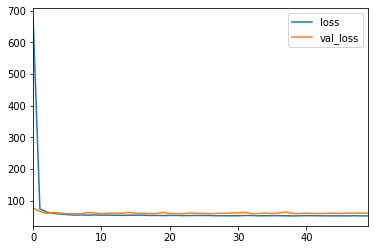

In [25]:
#checkpoint_sb = keras.callbacks.ModelCheckpoint("SOAI.h5", save_best_only=True)

history = model.fit(featuresTrain, targetTrain, epochs=epochs, validation_split=0.1, batch_size=batch)

#model = keras.models.load_model("SOAI.h5")

model.evaluate(featuresTest, targetTest)
predictionTest = model.predict(featuresTest)
predictionTrain = model.predict(featuresTrain)

pd.DataFrame(history.history).plot()

In [26]:
import pickle
model.save("VKCL.h5")
pickle.dump(scaler, open("./VKCL_scaler.sav", 'wb'))

Plot

Training set

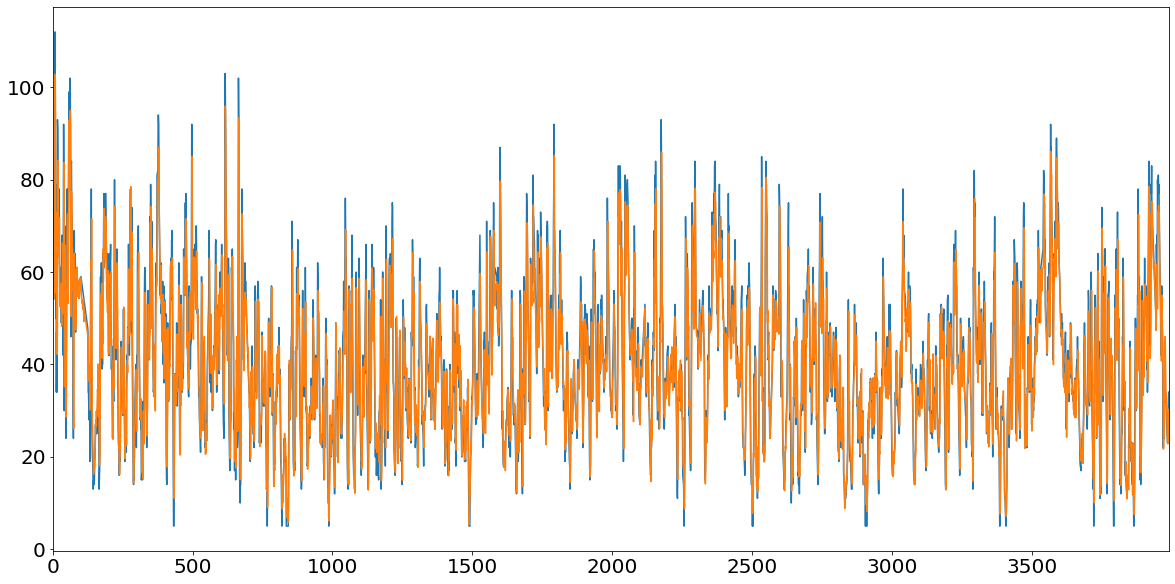

In [27]:
predictionTrain_plot = pd.Series(predictionTrain.T[0])
targetTrain_plot = pd.Series(targetTrain.T[0])

fig, ax = subplots()
targetTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)

Test set

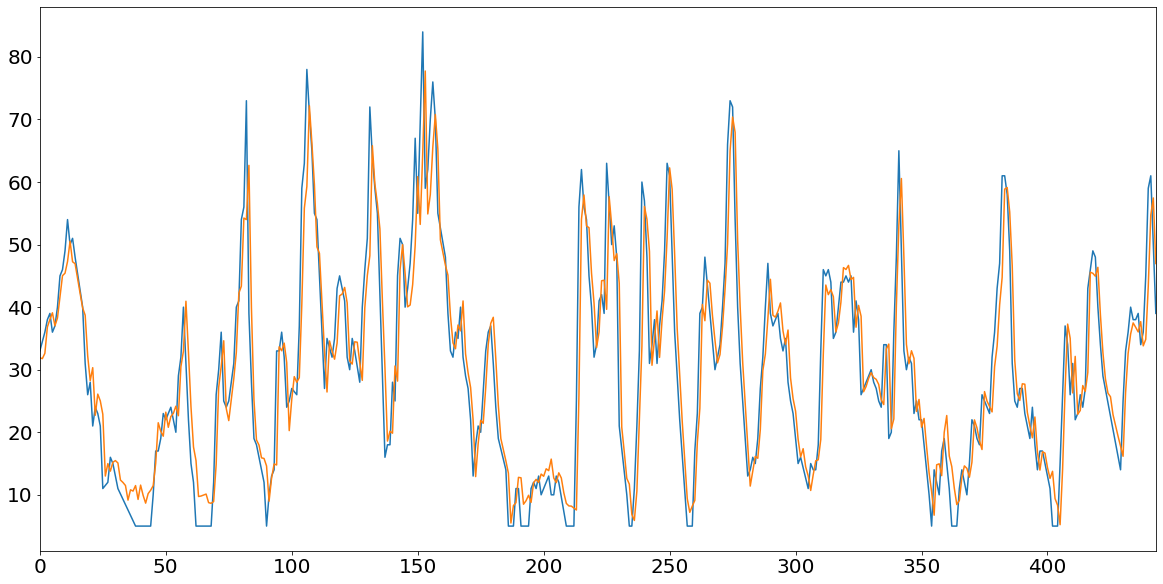

In [28]:
predictionTest_plot = pd.Series(predictionTest.T[0])
targetTest_plot = pd.Series(targetTest.T[0])

fig, ax = subplots()
targetTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)

### LSTM

Create data for LSTM

In [ ]:
if len(sensorIDs) > 1:
    print("WARNING")
    print("Using multiple sensors for training can lead to wrong slicing of the data regarding the timestamp.")

window = 2

featuresTrainLSTM = np.zeros(shape=(len(featuresTrain)-window,window,nFeatures))
targetTrainLSTM = np.zeros(shape=(len(featuresTrain)-window))
indexTrainLSTM = indexTrain[window:len(indexTrain)]

featuresTestLSTM = np.zeros(shape=(len(featuresTest)-window,window,nFeatures))
targetTestLSTM = np.zeros(shape=(len(featuresTest)-window))
indexTestLSTM = indexTest[window:len(indexTest)]

index = 0
for i in range(window, len(featuresTrain), 1):
    featuresTrainWindow = featuresTrain[i-window:i] 
    featuresTrainLSTM[index] = featuresTrainWindow
    targetTrainLSTM[index] = targetTrain[i-1]
    index += 1
    
index = 0
for i in range(window, len(featuresTest), 1):
    featuresTestWindow = featuresTest[i-window:i] 
    featuresTestLSTM[index] = featuresTestWindow
    targetTestLSTM[index] = targetTest[i-1]
    index += 1

Create model

In [ ]:
seed_value= 40

tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

epochs=50
batch=20
lr = 0.005

input1 = tf.keras.Input((window, nFeatures,))
lstm1 = tf.keras.layers.LSTM(10)(input1)
#dense1 = tf.keras.layers.Dense(5, activation="relu")(lstm1)
#dense2 = tf.keras.layers.Dense(10, activation="relu")(dense1)
#dense3 = tf.keras.layers.Dense(5, activation="relu")(dense2)
output = tf.keras.layers.Dense(1, activation="linear")(lstm1) # activation="linear"

modelLSTM = tf.keras.Model(inputs=[input1], outputs=[output])
modelLSTM.compile(optimizer=tf.keras.optimizers.Adam(lr, decay=lr/epochs), loss="mse")

In [ ]:
modelLSTM.summary()

Train model

In [ ]:
#checkpoint_sb = keras.callbacks.ModelCheckpoint("SOAILSTM.h5", save_best_only=True)


history = modelLSTM.fit(featuresTrainLSTM, targetTrainLSTM, epochs=epochs, batch_size=batch)

#modelLSTM = keras.models.load_model("SOAILSTM.h5")

modelLSTM.evaluate(featuresTestLSTM, targetTestLSTM)
prediction = modelLSTM.predict(featuresTestLSTM)
predictionTrain = modelLSTM.predict(featuresTrainLSTM)

pd.DataFrame(history.history).plot()

Plot result

Training set

In [ ]:
predictionTrain_LSTM = pd.Series(predictionTrain.T[0], index=indexTrainLSTM)
targetTrain_LSTM = pd.Series(targetTrain.T[0], index=indexTrain)

fig, ax = subplots()
targetTrain_LSTM.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTrain_LSTM.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorIDs, fontsize=25)

Test set

In [ ]:
predictionTest_LSTM = pd.Series(prediction.T[0], index=indexTestLSTM)
targetTest_LSTM = pd.Series(targetTest.T[0], index=indexTest)

fig, ax = subplots()
targetTest_LSTM.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTest_LSTM.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorIDs, fontsize=25)

### Classifier (up and down)

Append column with classification information (use dataTrainList instead of dataTrain in order not to mix times of sensors)

In [ ]:
dataTrainClassifierList = []
for data in dataTrainList:
    featureUpAndDown = []
    no2Values = data["no2_ip"]
    for i in range(0, len(no2Values)-1):
        upAndDown = 0
        if no2Values[i+1] > no2Values[i]:
            upAndDown = 1
        else:
            upAndDown = 0

        featureUpAndDown.append(upAndDown)

    featureUpAndDown.append(0)

    data["no2_ip_trend"] = featureUpAndDown
    
    dataTrainClassifierList.append(data)

dataTrainClassifier = pd.concat(dataTrainClassifierList)

In [ ]:
featureNames = ["rgreen", "rorange", "rred", "rbrown", "hum_ip", "temp_ip", "wg_ip", "wr_cos_ip", "wr_sin_ip"]
targetName = ["no2_ip_trend"]
nFeatures = len(featureNames)

dataTrainClassifier = dataTrainClassifier.dropna(subset=featureNames + targetName)

features = dataTrainClassifier[featureNames].values
target = dataTrainClassifier[targetName[0]].values
indexTime = dataTrainClassifier.index

In [ ]:
#scalerClassifier = MinMaxScaler()
scalerClassifier = StandardScaler()
#scalerClassifier = RobustScaler(with_scaling=False)
featuresScaled = scalerClassifier.fit_transform(features)

Train

In [ ]:
seed_value= 40

tf.keras.backend.clear_session()
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

epochs=50
batch=10
lr = 0.01

input1 = tf.keras.Input((nFeatures,))
dense1 = tf.keras.layers.Dense(10, activation="relu")(input1)
dense2 = tf.keras.layers.Dense(5, activation="relu")(dense1)
#dense3 = tf.keras.layers.Dense(5, activation="relu")(dense2)
output = tf.keras.layers.Dense(1, activation="sigmoid")(dense2) # activation="linear"

model = tf.keras.Model(inputs=[input1], outputs=[output])
model.compile(optimizer=tf.keras.optimizers.Adam(lr, decay=lr/epochs), loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

In [ ]:
#checkpoint_sb = keras.callbacks.ModelCheckpoint("SOAI.h5", save_best_only=True)

history = model.fit(featuresTrain, targetTrain, epochs=epochs, validation_split=0.1, batch_size=batch)

#model = keras.models.load_model("SOAI.h5")

model.evaluate(featuresTest, targetTest)
prediction = model.predict(featuresTest)
predictionTrain = model.predict(featuresTrain)

pd.DataFrame(history.history).plot()

Plot

Training set

In [ ]:
predictionTrain_plot = pd.Series(predictionTrain.T[0], index=indexTrain)
targetTrain_plot = pd.Series(targetTrain, index=indexTrain)

fig, ax = subplots()
targetTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTrain_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)

Test set

In [ ]:
predictionTest_plot = pd.Series(prediction.T[0], index=indexTest)
targetTest_plot = pd.Series(targetTest, index=indexTest)

fig, ax = subplots()
targetTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
predictionTest_plot.plot(figsize=(20,10), fontsize=20, ax=ax)
ax.set_title(sensorID, fontsize=25)